<a href="https://colab.research.google.com/github/aaron-philip/FDTD-Laplacian/blob/main/Heat_Laplacian_NIF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Emulator:
**Motivation:**

We have now observed just how computationally intensive it is to use a finite difference solver, even for small volumes over small time ranges. The goal here is to see if we can "invest" lots of time into training an ML model so that when we ask for some state in the future, we do not have to integrate through time to obtain the solution, but rather obtain it immediately. We will use the FD solver to generate training data and will utilize Physics Informed Machine Learning (https://www.sciencedirect.com/science/article/pii/S0021999118307125) to force the model to learn the underlying physical equation as well as possible. The model structure we will use is the Neural Implicit Flow model (https://arxiv.org/abs/2204.03216) which is designed to learn spatio-temporal data.


##Research Question:##

Can our ML model learn the physics at play by training on sparse data well enough to 
- interpolate in space
- extrapolate in time

This means that if we only train our model on data of the sphere dropped in a few spots, it can learn what should happen when we drop it somewhere in between those spots. This we can compare to our FD solver to determine if it is realistic. 

Likewise, can our model learn what happens to the heat much farther forward in time if we only show it about 1 second of heat spreading in the volume? We can test this by seeing if we reach a steady state value very far in time.  


In [ ]:
!pip install git+https://github.com/pswpswpsw/nif.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pswpswpsw/nif.git to /tmp/pip-req-build-093nvsoi
  Running command git clone -q https://github.com/pswpswpsw/nif.git /tmp/pip-req-build-093nvsoi
     |████████████████████████████████| 238 kB 2.8 MB/s 
  Created wheel for NIF: filename=NIF-1.0.1-py3-none-any.whl size=2946550 sha256=0d04c82a7be090041c7d95e37238dc793ce76d0496e06af12c34910c0e5e1b85
  Stored in directory: /tmp/pip-ephem-wheel-cache-wgmgdftp/wheels/88/ba/9a/716e4d26db4b1364836a1dd0bfa96bb8d89b1e67736b0da3fb
Successfully built NIF


In [ ]:
import tensorflow as tf
import nif
import numpy as np
from scipy.integrate import solve_ivp
import time
import logging
import contextlib
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from nif.optimizers import centralized_gradients_for_optimizer
import math

1 Physical GPUs, 1 Logical GPUs


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Simplifications

To make this computationally tractable, we need to make some simplifying assumptions. Hence, this model will not be able to consider any arbitrary situation, but should evaluate certain situations much, much faster than our FD solver was able to. 

**Assumptions:**
- The grid passed in will be of a fixed size and resolution. 
- The initial state of the system is uniform except for one 'sphere' of heat that will propagate through the volume. 
- Thermal diffusivity is the same everywhere; note that this is a measure of how fast heat can spread, so there is no need to consider this as a parameter because we can always scale our results in time if considering various thermal diffusivities.

In [ ]:
# Checks whether a point is on our grid
def on_grid(x,y,z, grid):
    nx, ny, nz = grid.shape
    if x <= nx-1 and x >= 0 and y <= ny-1 and y >= 0 and z <= nz-1 and z >= 0:
        return True
    else:
        return False

# Generates our uniform box with a 'sphere' of heat
def gen_state0(x,y,z, T):
    state0 = np.zeros([32, 32, 32])
    adjacent_loc = [(x,y,z), # centered point
                    (x+1,y,z), (x,y+1,z), (x,y,z+1), 
                    (x-1,y,z),(x,y-1,z), (x,y,z-1)]
    for loc in adjacent_loc:
        if on_grid(*loc, state0):
            state0[loc] = T
    return state0

state1 = gen_state0(5,5,5, 20)
print(state1[5,6,5])

20.0


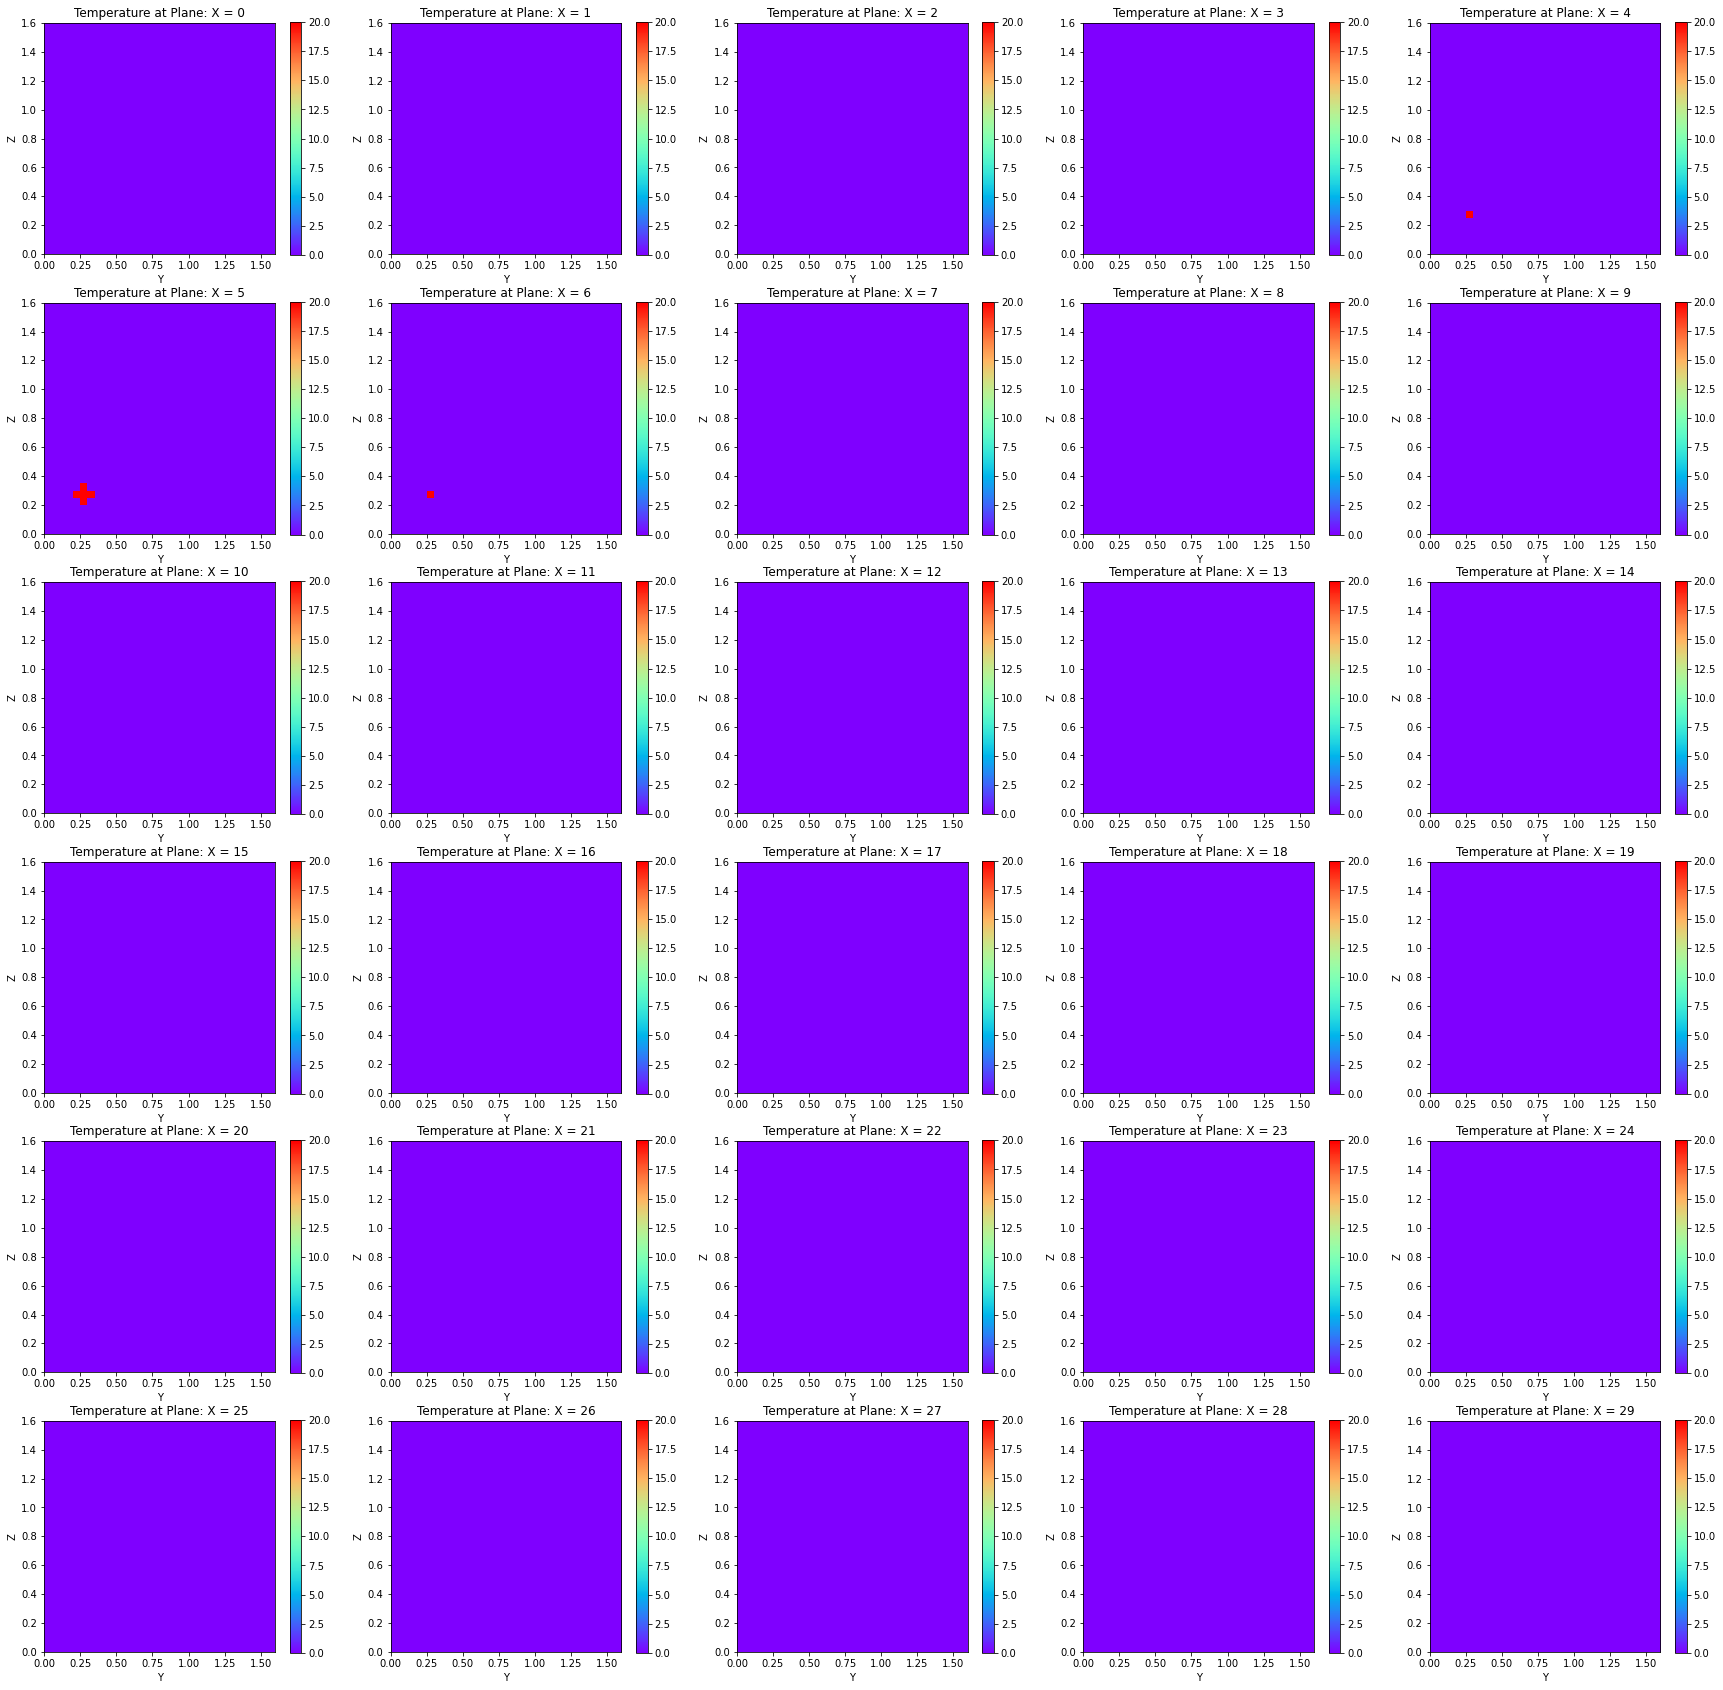

In [ ]:
dl = 0.05

# will plot a slice of the mesh of the temperature at a plane normal to the x-axis 
def plotxSlice(mesh, dl, x_slice, multiple=False):
    if multiple:     
        pos = plt.imshow(mesh[x_slice],vmin=np.min(mesh), vmax = np.max(mesh), 
                extent =[0, dl*np.shape(mesh[x_slice])[0], 0, dl*np.shape(mesh[x_slice])[1]],
                interpolation='nearest', cmap='rainbow', origin ='lower')
    else:
        pos = plt.imshow(mesh[x_slice],
                extent =[0, dl*np.shape(mesh[x_slice])[0], 0, dl*np.shape(mesh[x_slice])[1]],
                interpolation='nearest', cmap='rainbow', origin ='lower')
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title("Temperature at Plane: X = %s" % x_slice)
    plt.colorbar(pos)

# prints out various slices of our mesh to see the initial temperature distribution
plt.subplots(figsize=(30,30))
for i in range(0,30):
    plt.subplot(6,5,i+1)
    plotxSlice(state1, dl, i, multiple=True) 

## Finite Difference Solver: 
This is slightly adjusted to account for the thermal diffusivity being constant in space and time.

In [ ]:
def alpha(t,x,y,z, dl, TD=False):
    if TD: 
        x *= dl
        y *= dl
        z *= dl
        alpha = np.exp(-t*x*y) - np.cos(z**2) * np.sin(z)
    # uniform option
    else: 
        alpha = 0.05
    return alpha

# finite difference for 2nd order central difference
def FD_2nd(vector, dl):
    vxx = [0]
    for i in range(np.shape(vector)[0]-2):
        vxx.append((vector[i+2]+vector[i]-2*vector[i+1])/(dl**2))
    vxx.append(0)
    return np.array(vxx)

#calculates FD 2nd partial derivatives for the mesh in each dimension
def uxx(mesh,dl):
    nx, ny, nz = np.shape(mesh)
    uxx = np.zeros([nx, ny, nz]) 
    for y in range(ny):
        for z in range(nz):
            vector = []
            for i in range(nx):
                vector.append(mesh[i][y][z])
            vector = np.array(vector)
            FD = FD_2nd(vector, dl)
            for x in range(nx): 
                uxx[x][y][z] = FD[x]
    return uxx

def uyy(mesh,dl):
    nx, ny, nz = np.shape(mesh)
    uyy = np.zeros([nx, ny, nz]) 
    for x in range(nx):
        for z in range(nz):
            vector = []
            for i in range(ny):
                vector.append(mesh[x][i][z])
            vector = np.array(vector)
            FD = FD_2nd(vector, dl)
            for y in range(ny): 
                uyy[x][y][z] = FD[y]
    return uyy
def uzz(mesh, dl):
    nx, ny, nz = np.shape(mesh)
    uzz = np.zeros([nx, ny, nz])
    for x in range(nx):
        for y in range(ny):
            uzz[x][y] = FD_2nd(mesh[x][y], dl)
    return uzz

def ut(t, mesh, nx, ny, nz, dl):
    mesh = np.reshape(mesh, (nx, ny, nz))
    
    x = np.arange(nx).astype('f')
    x = np.repeat(x, ny*nz)
    y = np.arange(ny).astype('f')
    y = np.repeat(y, nx*nz)
    z = np.arange(nz).astype('f')
    z = np.repeat(z, nx*ny)
    
    ut = alpha(t, x, y, z, dl)*(uxx(mesh, dl)+uyy(mesh,dl)+uzz(mesh,dl))
    return np.reshape(ut, (-1))



## Example Evaluation of 1s: 

In [ ]:
st = time.time()
t_eval = np.arange(0,1, 0.005)
sol = solve_ivp(ut, t_span=(t_eval[0], t_eval[-1]), y0=np.reshape(state1, (-1)), t_eval=t_eval,args=(32, 32, 32, dl))
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 114.50672650337219 seconds


(32768, 200)


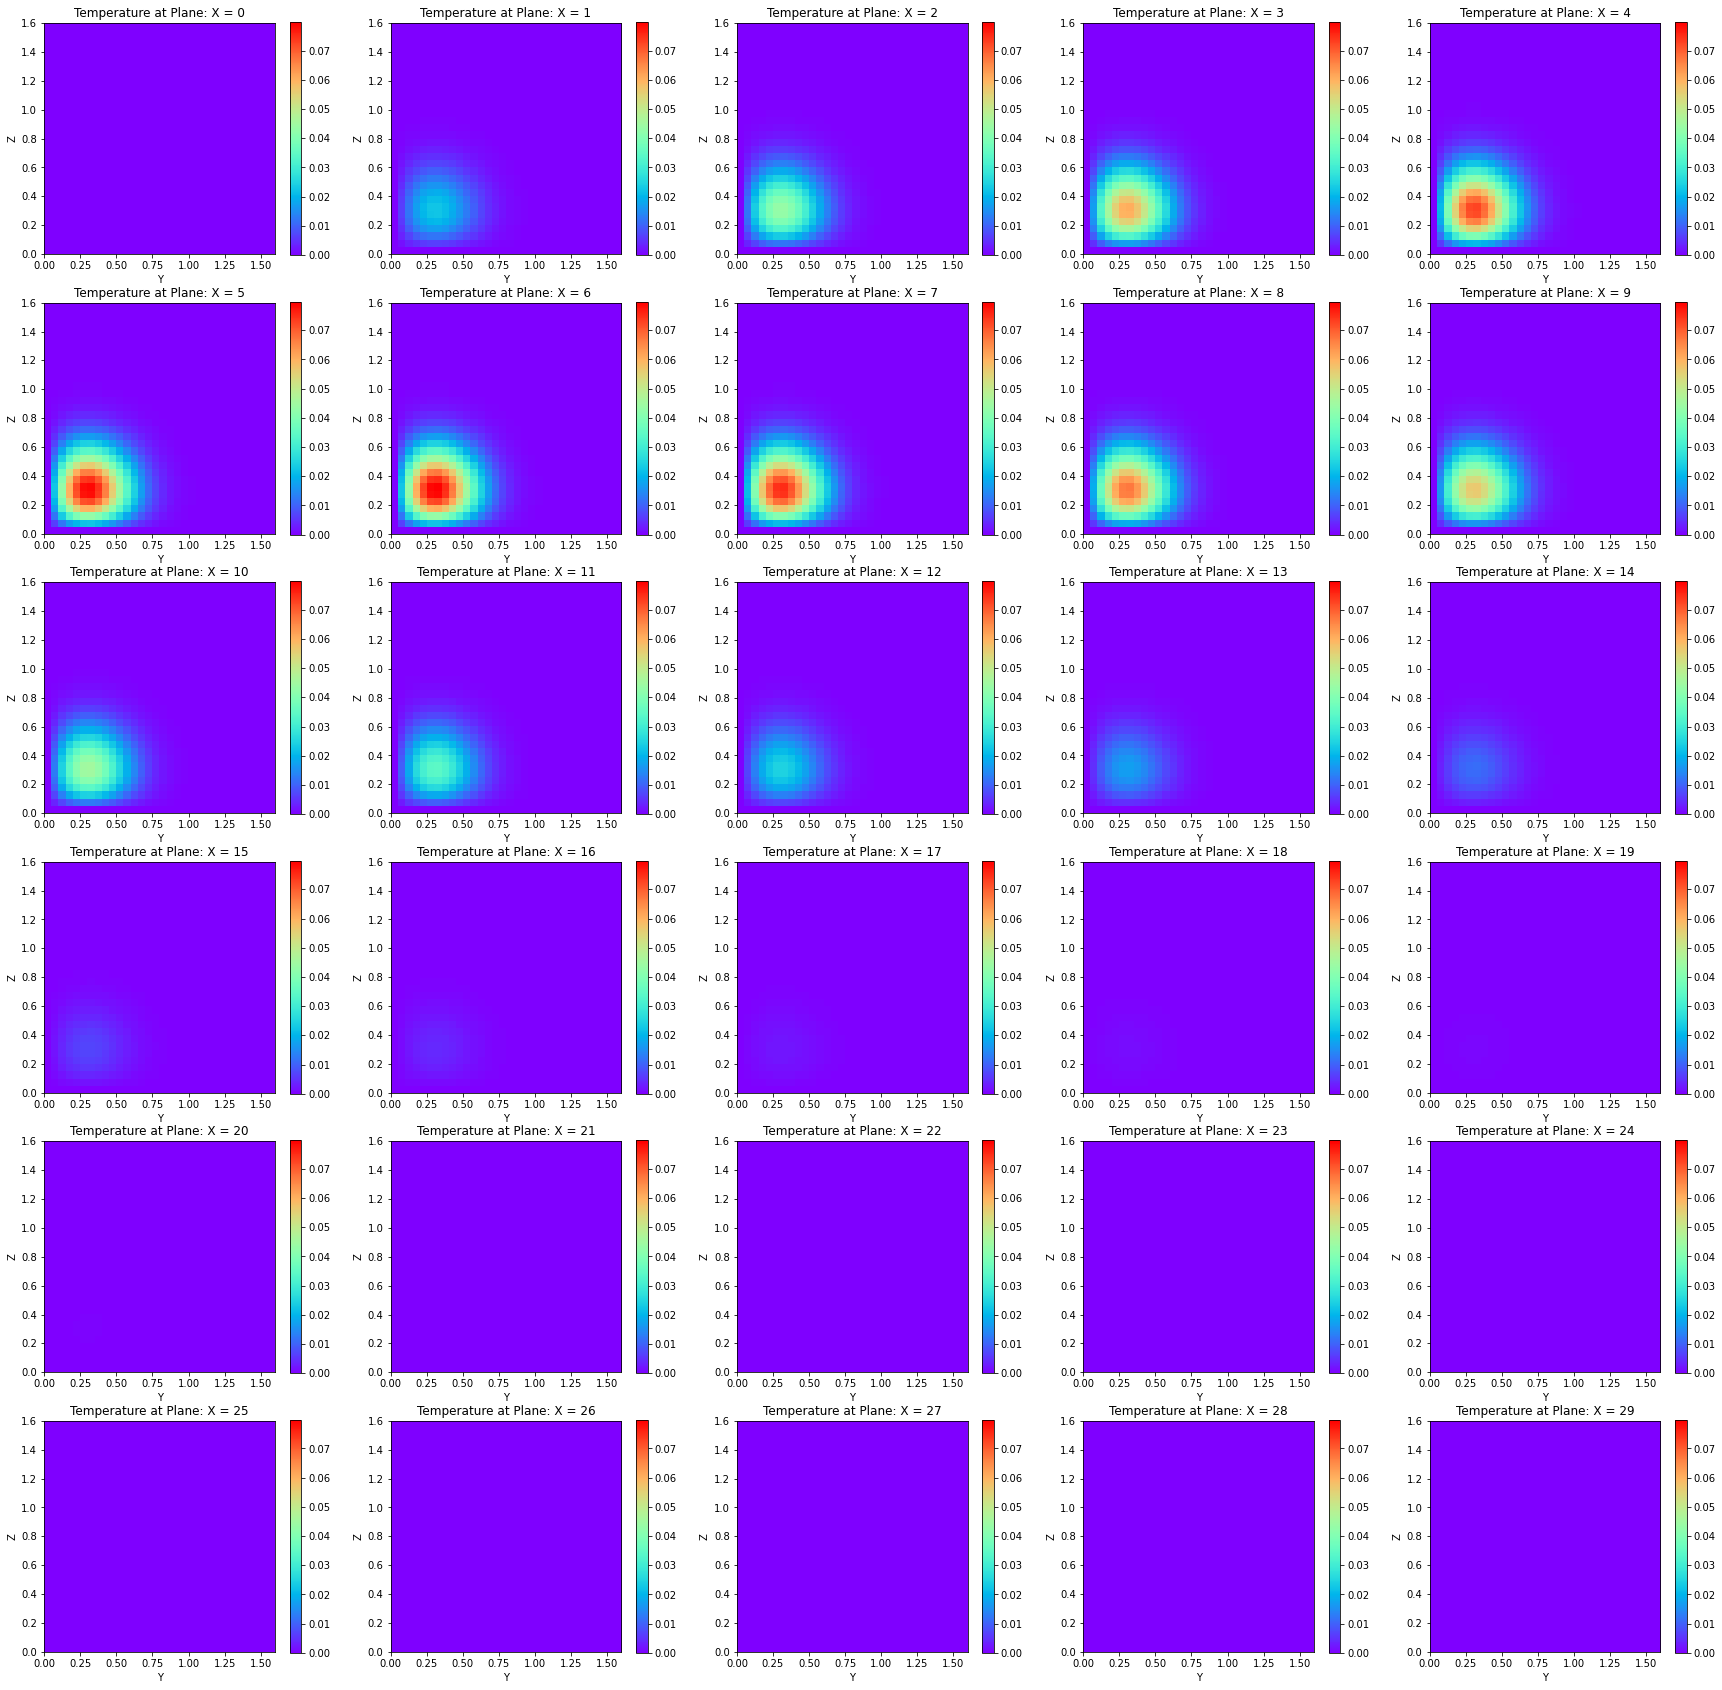

In [ ]:
print(np.shape(sol.y))
plt.subplots(figsize=(30,30))
y = np.reshape(sol.y.T[99], (32,32,32))
for i in range(0,30):
    plt.subplot(6,5,i+1)
    plotxSlice(y, dl, i, multiple=True)

## Generating Dataset
There are a few things worth exploring: 
- Can our model learn from sparse data (essentially can we give it very little data and can it 'fill in the gaps')? This is called interpolation. 
- Can it learn to predict outside of what it has seen (eg. can we ask it a question about the system much farther into the future than it was trained on and get a reasonable answer)? This is called extrapolation. 

Our dataset is generated by using the FD solver on 64 different initial states (eg. the sphere of heat starts somewhere different 64 times). Each system is integrated forward in time by 1 second. We coursen the data that the model sees by 8x (by skipping every other point on the grid in each dimension). This is a long task that takes ~ 2 hours just to generate enough data; this time and the training time of the model are important to consider when evaluating how useful an ML model is. Finally, the actual dataset is saved in my Google Drive so that it can be loaded at will.



In [ ]:
# Variety of initial conditions to propagate
state0_list = []
source_list = []
for x in range(4):
  for y in range(4):
    for z in range(4):
      source_list.append((x*8, y*8, z*8))
      state0_list.append(gen_state0(x*8, y*8, z*8, 200))

# Formats our data for a single state of the system
def generate_pt(t, state, source, dl):
  inpt = np.zeros((0,7))
  output = np.zeros((0,1))
  for x in range(1,state.shape[0],2):
    for y in range(1,state.shape[1],2):
      for z in range(1,state.shape[2],2):
        inpt = np.append(inpt, np.array([[t, source[0], source[1], source[2], x*dl, y*dl, z*dl]]), axis=0)
        output = np.append(output, np.array([[state[x][y][z]]]), axis=0)
  return inpt, output


# Assembling dataset
inputs = np.zeros((0,7))
outputs = np.zeros((0,1))
for i in range(len(state0_list)):
  if i % 8 == 0:
    print(i)
  t_eval = np.arange(0,1, 0.05)
  sol = solve_ivp(ut, t_span=(t_eval[0], t_eval[-1]), y0=np.reshape(state0_list[i], (-1)), t_eval=t_eval,args=(*state0_list[i].shape, dl)) 
  for t in range(20):
    y = np.reshape(sol.y.T[t], (32,32,32))
    inp,out = generate_pt(t*0.05, y, source_list[i], dl)
    inputs = np.append(inputs, inp, axis=0)
    outputs = np.append(outputs, out, axis=0)
np.save("drive/MyDrive/ColabNotebooks/Laplace-NIF_inputs.npy", inputs)
np.save("drive/MyDrive/ColabNotebooks/Laplace-NIF_outputs.npy", outputs)

0
8
16
24
32
40


In [ ]:
from sklearn.model_selection import train_test_split
x = np.load("drive/MyDrive/ColabNotebooks/Laplace-NIF_inputs.npy")
y = np.load("drive/MyDrive/ColabNotebooks/Laplace-NIF_outputs.npy")
batch_size = 512
print(x.shape, y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)
num_total_data = np.shape(X_train)[0]
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(num_total_data).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

print(np.shape(X_train))
print(np.shape(Y_train))

def generate(batch_size, total):
    count= 0
    while True:
        batch_index = 0
        batches_list = list(range(int(math.ceil(float(total) / batch_size))))

        while batch_index < len(batches_list):
            batch_index += 1
            count += 1
            yield (X_train[0:500],y[0:500])

(36700160,) (5242880,)


ValueError: ignored

In [ ]:
enable_multi_gpu = False
enable_mixed_precision = False

# mixed precision?
if enable_mixed_precision:
    mixed_policy = "mixed_float16"
    # we might need this for `model.fit` to automatically do loss scaling
    policy = nif.mixed_precision.Policy(mixed_policy)
    nif.mixed_precision.set_global_policy(policy)
else:
    mixed_policy = 'float32'

# custom callback 
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_begin_time = time.time()
        self.history_loss = []
        logging.basicConfig(filename='./log', level=logging.INFO, format='%(message)s')

    def on_epoch_begin(self, epoch, logs=None):
        self.ts = time.time()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % display_epoch == 0:
            tnow = time.time()
            te = tnow - self.ts
            logging.info("Epoch {:6d}: avg.loss pe = {:4.3e}, {:d} points/sec, time elapsed = {:4.3f} hours".format(
                epoch, logs['loss'], int(batch_size / te), (tnow - self.train_begin_time) / 3600.0))
            self.history_loss.append(logs['loss'])
        if epoch % print_figure_epoch == 0:
            plt.figure()
            plt.semilogy(self.history_loss)
            plt.xlabel('epoch: per {} epochs'.format(print_figure_epoch))
            plt.ylabel('MSE loss')
            plt.savefig('./loss.png')
            plt.close()

        if epoch % checkpt_epoch == 0 or epoch == nepoch - 1:
            print('save checkpoint epoch: %d...' % epoch)
            self.model.save_weights("drive/MyDrive/ColabNotebooks/Laplace-NIF/saved_weights/ckpt-{}/ckpt".format(epoch))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./tb-logs", update_freq='epoch')
%load_ext tensorboard
%tensorboard --logdir tb-logs

In [ ]:
# hyperparameters
cfg_shape_net = {
    "connectivity": 'full',
    "input_dim": 3,
    "output_dim": 1,
    "units": 30,
    "nlayers": 2,
    "activation": 'swish'
}
cfg_parameter_net = {
    "input_dim": 4,
    "latent_dim": 1,
    "units": 5,
    "nlayers": 1,
    "activation": 'swish',
}

nepoch = 100
learn = 1e-3
batch_size = 512
checkpt_epoch = nepoch/10
display_epoch = nepoch/100
print_figure_epoch = display_epoch



In [ ]:
def scheduler(epoch, lr):
  if epoch < nepoch/5:
        return learn
  elif epoch < nepoch/2.5:
        return learn/5
  elif epoch < nepoch/1.25:
        return learn/10
  else:
        return learn/50        
scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# Train from scratch

cm = tf.distribute.MirroredStrategy().scope() if enable_multi_gpu else contextlib.nullcontext()
with cm:

    optimizer = nif.optimizers.AdaBeliefOptimizer(learn)
    optimizer.get_gradients = centralized_gradients_for_optimizer(optimizer)
    loss_fun = tf.keras.losses.MeanSquaredError()
    model_ori = nif.NIF(cfg_shape_net, cfg_parameter_net, mixed_policy)
    model_opt = model_ori.build()
    model_opt.compile(optimizer, loss_fun)
    #model_opt.evaluate(X_train, Y_train)

callbacks = [tensorboard_callback, LossAndErrorPrintingCallback(), scheduler_callback]
model_opt.fit(generate(batch_size, 10000), epochs=nepoch, batch_size=batch_size,
          shuffle=False, steps_per_epoch=int(math.ceil(float(10000) / batch_size)), verbose=1, callbacks=callbacks,
          use_multiprocessing=True)

from IPython.display import Image, display

listOfImageNames = ['./loss.png',]

for imageName in listOfImageNames:
    display(Image(filename=imageName))

In [ ]:
def load_model(SNET_params, PNET_params, mixed_policy, ckptdir):
  new_model_ori = nif.NIF(SNET_params, PNET_params, mixed_policy)
  new_model = new_model_ori.model()
  optimizer = tf.keras.optimizers.Adam(learn)
  new_model.compile(optimizer, loss='mse')
  new_model.load_weights(ckptdir)
  return new_model

In [ ]:
new_model = load_model(cfg_shape_net, cfg_parameter_net, mixed_policy, "drive/MyDrive/ColabNotebooks/Laplace-NIF/saved_weights/ckpt-xxx/ckpt")